# My model that divides between road bikes and mountain bikes

In [21]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [22]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('road bicycle', max_images=1)
urls[0]

Searching for 'road bicycle'


'https://cdn.road.cc/sites/default/files/og-classic-6.jpg'

In [23]:
from fastdownload import download_url
dest = 'road bicycle.jpg'
download_url(urls[0], dest, show_progress=False)

Path('road bicycle.jpg')

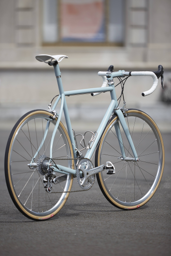

In [24]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'road bicycle photos'


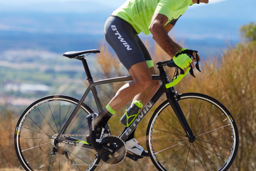

In [25]:
download_url(search_images('road bicycle photos', max_images=1)[0], 'road bicycle.jpg', show_progress=False)
Image.open('road bicycle.jpg').to_thumb(256,256)

In [26]:
searches = 'road bicycle','mountain bicycle'
path = Path('road_or_mountain')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'merida {o}'))
    download_images(dest, urls=search_images(f'trek {o}'))
    download_images(dest, urls=search_images(f'bmc {o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'merida road bicycle'
Searching for 'trek road bicycle'
Searching for 'bmc road bicycle'
Searching for 'merida mountain bicycle'
Searching for 'trek mountain bicycle'
Searching for 'bmc mountain bicycle'


## Step 2: Train our model

In [27]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

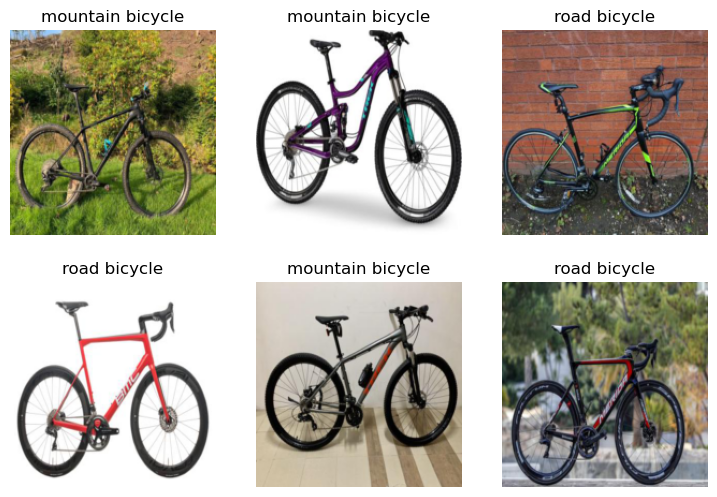

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.113734,0.631873,0.531250,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.432034,0.585720,0.531250,00:01
1,0.336226,0.593561,0.531250,00:01
2,0.261419,0.556123,0.531250,00:01
3,0.201139,0.357068,0.531250,00:01
4,0.155156,0.247737,0.531250,00:01
5,0.125216,0.207040,0.531250,00:01
6,0.103138,0.193366,0.531250,00:01
7,0.087353,0.194321,0.531250,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bicycle we downloaded at the start:

In [32]:
bike_type,_,probs = learn.predict(PILImage.create('road bicycle.jpg'))
print(f"This is a: {bike_type}.")
print(f"Probability it's a road bike: {probs[1]:.4f}")

This is a: road bicycle.
Probability it's a road bike: 0.9914


## Step 4: Another test

Searching for 'expencive road bicycle'


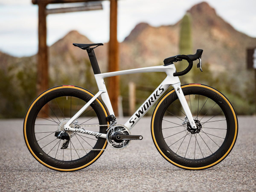

In [33]:
prompt = "expencive road bicycle"

download_url(search_images(prompt, max_images=1)[0], f'{prompt}.jpg', show_progress=False)
Image.open(f'{prompt}.jpg').to_thumb(256,256)

In [34]:
bike_type,_,probs = learn.predict(PILImage.create( f'{prompt}.jpg'))
print(f"This is a: {bike_type}.")
print(f"Probability it's a road bike: {probs[1]:.4f}")

This is a: road bicycle.
Probability it's a road bike: 0.9984


Searching for 'expencive mountain bicycle'


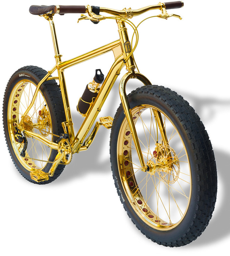

In [35]:
prompt = "expencive mountain bicycle"

download_url(search_images(prompt, max_images=1)[0], f'{prompt}.jpg', show_progress=False)
Image.open(f'{prompt}.jpg').to_thumb(256,256)

In [36]:
bike_type,_,probs = learn.predict(PILImage.create( f'{prompt}.jpg'))
print(f"This is a: {bike_type}.")
print(f"Probability it's a road bike: {probs[1]:.4f}")

This is a: mountain bicycle.
Probability it's a road bike: 0.3321


## Step 5: My bike

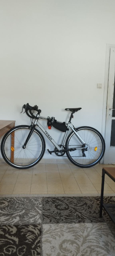

In [38]:
my_bike_file = f'my_bike.jpg'
Image.open(my_bike_file).to_thumb(256,256)

In [39]:
bike_type,_,probs = learn.predict(PILImage.create(my_bike_file))
print(f"This is a: {bike_type}.")
print(f"Probability it's a road bike: {probs[1]:.4f}")

This is a: road bicycle.
Probability it's a road bike: 0.8167
